# Simulating Qutrit Circuits

The `QutritRestlessSimulator` supports circuits with qutrit instructions. These instructions can be
unitary or general completely-positive trace-preserving maps. These two types are represented by the
`QutritUnitaryGate` and `QutritQuantumChannelOperation` classes respectively.

This tutorial covers how to create qutrit circuits and how to simulate them. We use the same types
of circuits as in the introductory tutorial but with a leaky initial $R_X(\pi/2)$ gate.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import RXGate
from qiskit.quantum_info import Kraus

from restless_simulator.circuit import QutritQuantumChannelOperation, QutritUnitaryGate
from restless_simulator.simulator import QutritRestlessSimulator

In [2]:
# Create simulator
simulator = QutritRestlessSimulator()

## Creating Qutrit Circuits

Qutrit circuits are standard Qiskit `QuantumCircuit` instances but with special qutrit
instructions, which we add using `QuantumCircuit.append`. The simulator supports mixed instructions,
allowing for qubit and qutrit instructions to coexist in the same circuit. Qubit instructions will
be converted from their $2\times{}2$ unitaries to ideal $3\times{}3$ unitaries.

In this section we will look at creating a _leaky_ variant of the circuit in the `introduction to
the simulator` tutorial, i.e., a leaky $R_X(\pi/2)$ gate followed by a sequence of ideal $R_X(\pi/3)$
gates. The leaky gate will reduce the contrast of our measurements as the $|2\rangle$ population
will now be non-zero. The $R_X(\pi/3)$ gates will not interact with the $|2\rangle$-state population
as they are ideal. The default measurement assignment for the simulator assigns the `"1"` label to
the $|2\rangle$ state, which means that by default it cannot distinguish between $|1\rangle$ and
$|2\rangle$. This can be changed by setting the `meas_assignment_mat` option of the simulator.

First we create a NumPy array of our leaky unitary gate as an ideal $R_X(\pi/2)$ rotation between
$|0\rangle$ and $|1\rangle$ and a small rotation from $|1\rangle$ into the $|2\rangle$ state. This
final rotation is controlled by the `leakage_rotation` variable.


In [3]:
# Variable to control leakage
leakage_rotation = np.pi / 16
# Construct leaky gate as two rotations.
leaky_unitary = (
    # very small rotation from |1> to |2>
    np.array(
        [
            [1, 0, 0],
            [0, np.cos(leakage_rotation / 2), -1j * np.sin(leakage_rotation / 2)],
            [0, -1j * np.sin(leakage_rotation / 2), np.cos(leakage_rotation / 2)],
        ],
    )
    # X-pi/2 rotation between |0> and |1>
    @ np.array(
        [
            [np.cos(np.pi / 4), -1j * np.sin(np.pi / 4), 0],
            [-1j * np.sin(np.pi / 4), np.cos(np.pi / 4), 0],
            [0, 0, 1],
        ]
    )
)


Now that we have our leaky unitary, we create an instance of `QutritUnitaryGate` with our unitary
matrix. We then construct leaky circuits and use our leaky gate as the first gate. We also create
circuits with an ideal $R_X(\pi/2)$ gate against which we will compare our measurements.


In [4]:
leaky_gate = QutritUnitaryGate(leaky_unitary, label="U(pi/2)")
ideal_gate = RXGate(np.pi / 2)


In [5]:
N_CIRCUITS = 10
leaky_circuits = []
ideal_circuits = []
for n in range(N_CIRCUITS):
    # Create leaky circuit
    nth_circ = QuantumCircuit(1)
    # Add leaky gate to qubit/qutrit 0.
    nth_circ.append(
        leaky_gate,
        [0],
    )
    # Add ideal qubit RX(pi/3) gates.
    for _ in range(n):
        nth_circ.rx(np.pi / 3, 0)
    leaky_circuits.append(nth_circ)

    # Create ideal circuit
    nth_ideal_circ = QuantumCircuit(1)
    nth_ideal_circ.append(
        ideal_gate,
        [0],
    )
    for _ in range(n):
        nth_ideal_circ.rx(np.pi / 3, 0)
    ideal_circuits.append(nth_ideal_circ)


Here we can compare the ideal and leaky circuits. Notice that only the first gate is different.

In [6]:
ideal_circuits[-1].draw()

┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐»
q: ┤ Rx(π/2) ├┤ Rx(π/3) ├┤ Rx(π/3) ├┤ Rx(π/3) ├┤ Rx(π/3) ├┤ Rx(π/3) ├»
   └─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘»
«   ┌─────────┐┌─────────┐┌─────────┐┌─────────┐
«q: ┤ Rx(π/3) ├┤ Rx(π/3) ├┤ Rx(π/3) ├┤ Rx(π/3) ├
«   └─────────┘└─────────┘└─────────┘└─────────┘

In [7]:
leaky_circuits[-1].draw()

┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐┌─────────┐»
q: ┤ U(pi/2) ├┤ Rx(π/3) ├┤ Rx(π/3) ├┤ Rx(π/3) ├┤ Rx(π/3) ├┤ Rx(π/3) ├»
   └─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘»
«   ┌─────────┐┌─────────┐┌─────────┐┌─────────┐
«q: ┤ Rx(π/3) ├┤ Rx(π/3) ├┤ Rx(π/3) ├┤ Rx(π/3) ├
«   └─────────┘└─────────┘└─────────┘└─────────┘

## Simulating Qutrit Circuits

We simulate our circuits in exactly the same way as in the first tutorial "Simulating Circuits with
the Restless Simulator". As we have not modified the measurement assignment matrix, our measurements
default to qubit discrimination.

In [8]:
leaky_job = simulator.run(leaky_circuits)
ideal_job = simulator.run(ideal_circuits)

## Results

To plot the results we use the restless post-processing functions provided in the `utils` module of
the restless simulator package.

In [9]:
from restless_simulator.utils import (
    extract_memory,
    restless_memory_to_memory,
    memory_to_probabilities,
)


To compare against the expected results, we also compute the expected probabilities as was done in the introductory tutorial.

In [10]:
expected_probs = (
    0.5 * np.cos(np.pi / 3 * np.arange(N_CIRCUITS, step=0.1) + np.pi / 2) + 0.5
)

As you can see, the measurements with a leaky initial $R_X(\pi/2)$ gate contaminate the measurement
results and give values that deviate from the ideal. In the next tutorial, "Standard Circuit
Execution with the Restless Simulator", you will see how the simulator can be used with standard
circuit execution and how leakage accumulates during restless circuit execution.

Text(0, 0.5, 'Probability to Measure $|0\\rangle$')

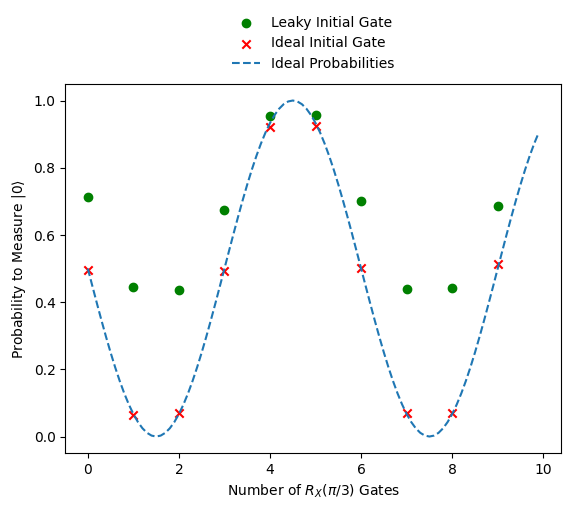

In [12]:
plt.scatter(
    range(N_CIRCUITS),
    memory_to_probabilities(restless_memory_to_memory(extract_memory(leaky_job))),
    label="Leaky Initial Gate",
    marker="o",
    color="g",
)
plt.scatter(
    range(N_CIRCUITS),
    memory_to_probabilities(restless_memory_to_memory(extract_memory(ideal_job))),
    label="Ideal Initial Gate",
    marker="x",
    color="r",
)
plt.plot(np.arange(N_CIRCUITS, step=0.1), expected_probs, linestyle="--", label="Ideal Probabilities")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.0), frameon=False)
plt.xlabel("Number of $R_X(\\pi/3)$ Gates")
plt.ylabel("Probability to Measure $|0\\rangle$")